# Project Summary

The goal of the project is to predict 1 month ahead store-item level monthly sales for IC Company. In this notebook, company sales and store sales based on monthly and daily data are forecasted using the Prophet package. Historical weights are assigned to items to make item-level predictions. Parameters of the models are tuned using cross validation. Models are evaluated using expanding windows and the best prediction model is selected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
import itertools

In [2]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_yearly

In [3]:
import time
import tqdm

In [4]:
ts_m=pd.read_csv('company_monthly.csv')
ts_m.head()

,year_month,item_cnt_day
0,2013-01,113903.0
1,2013-02,130610.0
2,2013-03,131621.0
3,2013-04,104586.0
4,2013-05,109274.0


In [5]:
ts_d=pd.read_csv('company_daily.csv')
ts_d.head()

,date,item_cnt_day
0,2013-01-01,1951.0
1,2013-01-02,3817.0
2,2013-01-03,3500.0
3,2013-01-04,2368.0
4,2013-01-05,4662.0


## Prophet

### Prediction for Company Level- Monthly Data and Daily Data

In [6]:
ts_m['year_month']=pd.to_datetime(ts_m.year_month)
ts_m.columns=['ds','y']
ts_m.head()

,ds,y
0,2013-01-01,113903.0
1,2013-02-01,130610.0
2,2013-03-01,131621.0
3,2013-04-01,104586.0
4,2013-05-01,109274.0


In [7]:
model = Prophet(yearly_seasonality=True)
model.fit(ts_m) 

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
future = model.make_future_dataframe(periods = 1, freq = 'MS')  
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
30,2015-07-01,61653.218081,57844.417309,65540.759909
31,2015-08-01,67567.235797,64159.663798,71123.580895
32,2015-09-01,61513.844760,57866.207039,65253.645094
33,2015-10-01,56818.683898,52939.999243,60680.273953
34,2015-11-01,86407.964166,82679.548092,90023.282966


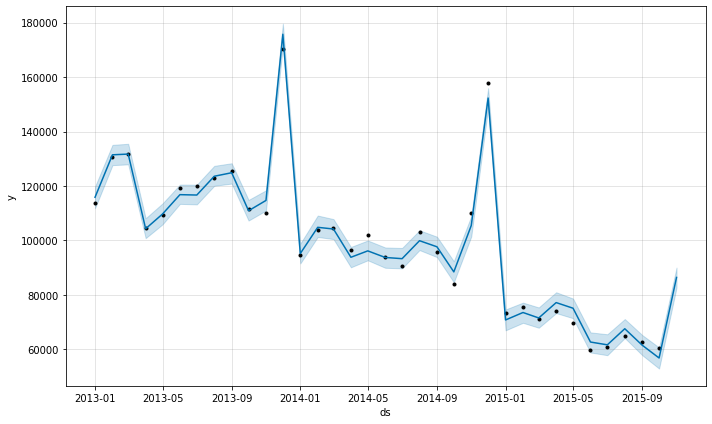

In [9]:
model.plot(forecast);

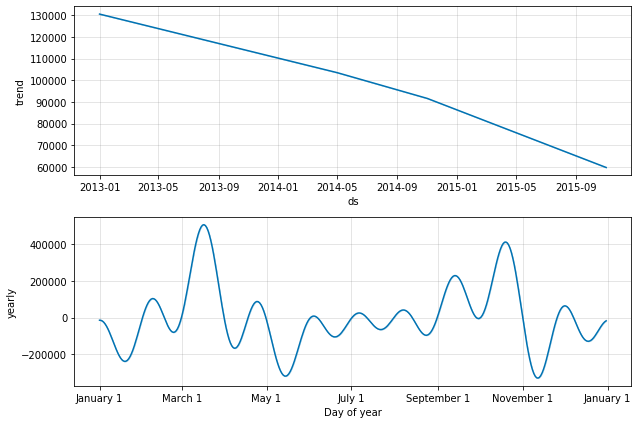

In [10]:
model.plot_components(forecast);

In [11]:
#tune paraameters
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(ts_m)  # Fit model with given params
    df_cv = cross_validation(m, initial='366 days', period='180 days',horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-04-04 00:00:00 and 2014-10-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-04-04 00:00:00 and 2014-10-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

    changepoint_prior_scale  seasonality_prior_scale           rmse
0                     0.001                     0.01   21734.063562
1                     0.001                     0.10   10891.278828
2                     0.001                     1.00   17669.850304
3                     0.001                    10.00   15358.686148
4                     0.010                     0.01   21707.897835
5                     0.010                     0.10   10738.560364
6                     0.010                     1.00    9050.307774
7                     0.010                    10.00   36875.506022
8                     0.100                     0.01   21677.702967
9                     0.100                     0.10   11593.292162
10                    0.100                     1.00   15430.159113
11                    0.100                    10.00   10613.348334
12                    0.500                     0.01   33850.074048
13                    0.500                     

In [12]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


In [13]:
m1 = Prophet(yearly_seasonality=True,changepoint_prior_scale=0.01, seasonality_prior_scale=1.0)
m1.fit(ts_m) 
future1 = m1.make_future_dataframe(periods = 1, freq = 'MS')  
forecast1 = m1.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
30,2015-07-01,64309.401645,59521.939813,68900.815687
31,2015-08-01,70481.886983,65712.962818,74841.715723
32,2015-09-01,64539.809162,59666.159141,69454.799343
33,2015-10-01,59386.279924,54906.717124,63849.886541
34,2015-11-01,94998.478946,90407.975009,99769.547317


In [14]:
df_cv_1 = cross_validation(m1, initial='366 days', period='30 days', horizon = '365 days')
#df_cv_1

INFO:fbprophet:Making 10 forecasts with cutoffs between 2014-01-04 00:00:00 and 2014-10-01 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


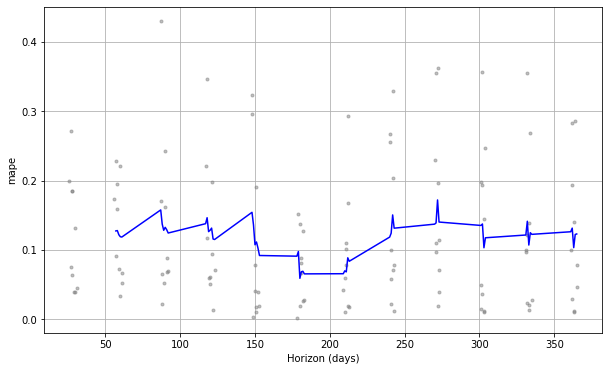

In [15]:
fig_1 = plot_cross_validation_metric(df_cv_1, metric='mape')

In [16]:
ts_d.columns=['ds','y']

In [17]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params,yearly_seasonality=True,weekly_seasonality=True)  # Fit model with given params
    m.add_country_holidays(country_name='RU')
    m.fit(ts_d)
    df_cv = cross_validation(m, initial='366 days', period='180 days',horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
#print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-05-04 00:00:00 and 2014-10-31 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-05-04 00:00:00 and 2014-10-31 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-05-04 00:00:00 and 2014-10-31 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-05-04 00:00:00 and 2014-10-31 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-05-04 00:00:00 and 2014-10-31 00:0

In [18]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


In [19]:
m2 = Prophet(yearly_seasonality=True,weekly_seasonality=True,changepoint_prior_scale=0.1, seasonality_prior_scale=1.0)
m2.add_country_holidays(country_name='RU')
m2.fit(ts_d) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


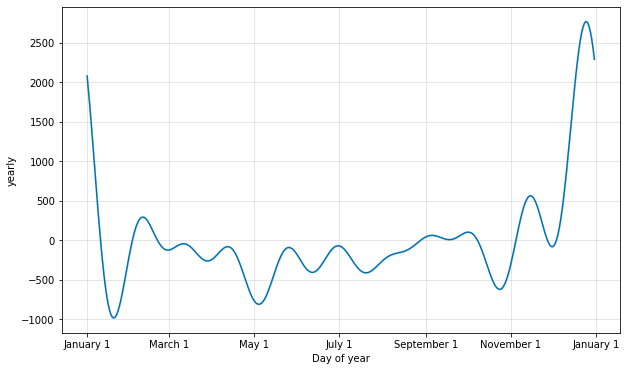

In [20]:
a = plot_yearly(m2)

In [21]:
future2 = m2.make_future_dataframe(periods = 30)  
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1039,2015-11-26,1835.508893,460.237943,3304.267255
1040,2015-11-27,2324.046323,922.953200,3715.349479
1041,2015-11-28,3083.421349,1656.090891,4509.181809
1042,2015-11-29,2416.958637,1005.640871,3848.012152
1043,2015-11-30,1577.601748,173.493358,3013.849201


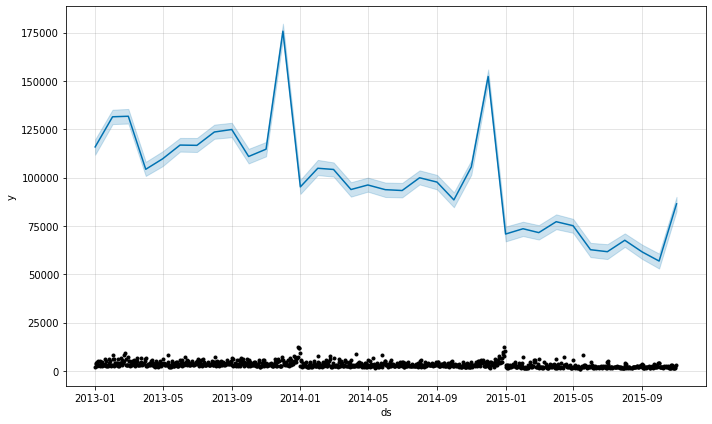

In [22]:
m2.plot(forecast);

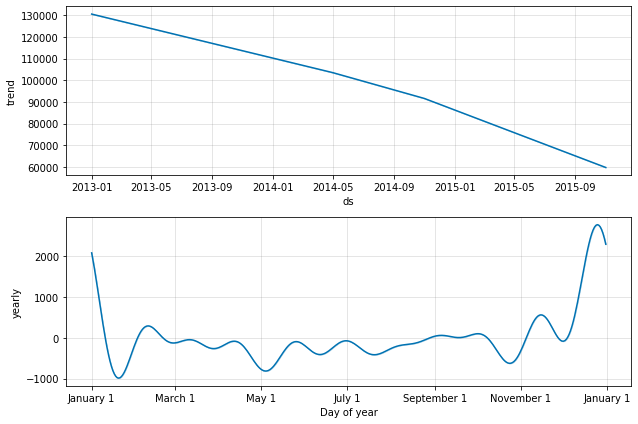

In [23]:
m2.plot_components(forecast);

In [24]:
df_cv_2 = cross_validation(m2, initial='366 days', period='180 days', horizon = '365 days')
#df_cv_2

INFO:fbprophet:Making 2 forecasts with cutoffs between 2014-05-04 00:00:00 and 2014-10-31 00:00:00


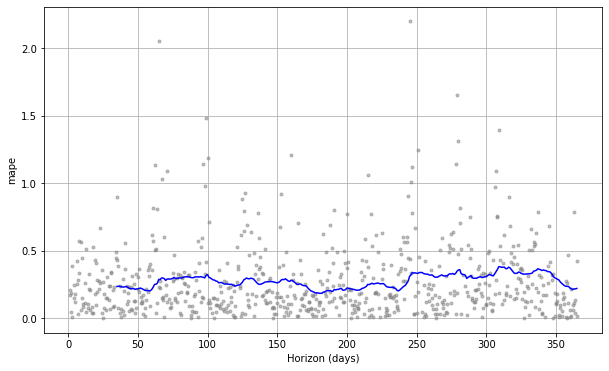

In [25]:
fig = plot_cross_validation_metric(df_cv_2, metric='mape')

In [26]:
f2=forecast2[['ds','yhat']]
f2['year_month']=f2['ds'].dt.strftime('%Y-%m-%d').str[:7]
f2_yhat=f2.groupby(['year_month'])['yhat'].sum().reset_index()
#f2_yhat

/Users/ruoqigao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df_m=pd.DataFrame()
for i in range(12,35):
    m1 = Prophet(yearly_seasonality=True,changepoint_prior_scale=0.01, seasonality_prior_scale=1.0)
    m1.fit(ts_m[:i]) 
    future1 = m1.make_future_dataframe(periods = 1, freq = 'MS')  
    forecast1 = m1.predict(future1)
    f=forecast1[['ds', 'yhat']].tail(1)
    df_m=df_m.append(f)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run p

In [28]:
df_d=pd.DataFrame()
for i in range(13,40):
    m2 = Prophet(yearly_seasonality=True,weekly_seasonality=True,changepoint_prior_scale=0.1, seasonality_prior_scale=1.0)
    m2.add_country_holidays(country_name='RU')
    m2.fit(ts_d[:i*26]) 
    if i!=39:
        future1 = m2.make_future_dataframe(periods = 26)
    else:
        future1 = m2.make_future_dataframe(periods = 30)
    forecast1 = m2.predict(future1)
    if i!=39:
        f=forecast1[['ds', 'yhat']].tail(26)
    else: 
        f=forecast1[['ds', 'yhat']].tail(30)
    df_d=df_d.append(f)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [29]:
df_m['year_month']=df_m['ds'].dt.strftime('%Y-%m-%d').str[:7]
df_d['year_month']=df_d['ds'].dt.strftime('%Y-%m-%d').str[:7]
df_d=df_d.groupby(['year_month'])['yhat'].sum().reset_index()
f_company=df_m.merge(df_d,on='year_month')
#f_company

In [30]:
ts_m=pd.read_csv('company_monthly.csv')
ts_m=ts_m[ts_m.year_month>'2014-01']
#ts_m

In [31]:
f_company=ts_m.merge(f_company,on='year_month',how='right')

In [32]:
#mse for monthly data prediction
mse_monthly=sum((f_company.yhat_x[:-2]-f_company.item_cnt_day[:-2])**2)/len(f_company[:-1])
print(mse_monthly)
#mse for daily data prediction
mse_daily=sum((f_company.yhat_y[:-2]-f_company.item_cnt_day[:-2])**2)/len(f_company[:-1])
print(mse_daily)

200882760.40173805
132275135.46172066


### Prediction for Store Level- Monthly and Daily Data

In [33]:
ss_m=pd.read_csv('store_monthly.csv')

In [34]:
ss_d=pd.read_csv('store_daily.csv')
ss_d

,shop_id,date,item_cnt_day
0,0,2013-01-02,228.0
1,0,2013-01-13,144.0
2,0,2013-01-14,138.0
3,0,2013-01-15,153.0
4,0,2013-01-16,154.0
...,...,...,...
44455,59,2015-10-27,34.0
44456,59,2015-10-28,14.0
44457,59,2015-10-29,14.0
44458,59,2015-10-30,30.0


In [35]:
ss_m_pivot=ss_m.pivot(index='year_month', columns='shop_id', values='item_cnt_day')
ss_m_pivot.fillna(0,inplace=True)
ss_m_pivot.columns=range(0,58)

In [36]:
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ss_m_pivot.index=dates
ss_m_pivot.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
2013-01-01,3626.0,1955.0,748.0,670.0,1685.0,446.0,3403.0,2091.0,747.0,0.0,...,0.0,0.0,2981.0,2477.0,1677.0,1800.0,7814.0,205.0,2361.0,1704.0
2013-02-01,3957.0,2298.0,722.0,924.0,2069.0,1171.0,4042.0,2677.0,963.0,0.0,...,0.0,0.0,3583.0,2340.0,1858.0,2087.0,8556.0,234.0,3169.0,2063.0
2013-03-01,403.0,310.0,821.0,894.0,1806.0,1206.0,4370.0,2510.0,692.0,543.0,...,0.0,0.0,3761.0,2444.0,1831.0,2354.0,9117.0,205.0,2921.0,1944.0
2013-04-01,473.0,99.0,678.0,727.0,639.0,967.0,3130.0,1768.0,139.0,1573.0,...,0.0,0.0,2976.0,2005.0,1573.0,1725.0,7275.0,212.0,2284.0,1466.0
2013-05-01,465.0,242.0,659.0,783.0,1397.0,1007.0,3459.0,1859.0,139.0,2131.0,...,0.0,0.0,2945.0,1986.0,1652.0,1842.0,6948.0,728.0,2262.0,1545.0


In [37]:
def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=True,daily_seasonality=False,weekly_seasonality=False)
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=1, include_history=True,freq='MS')
    forecast = model.predict(forecast)
    forecast=forecast[['ds', 'yhat']].tail(1)
    return forecast

In [38]:
start_time = time.time()
df1_m=pd.DataFrame()
for j in range(12,35):
    ss_m_pivot_slice=ss_m_pivot[:j]
    for i in range(1,59):
        date=ss_m_pivot_slice.reset_index().iloc[:,0]
        shop=ss_m_pivot_slice.reset_index().iloc[:,i]
        ds=pd.concat([date, shop], axis=1)
        ds.columns=['ds','y']
        ds['ds']=pd.to_datetime(ds['ds'])
        f=run_prophet(ds)
        f['shop_id']=ss_m_pivot_slice.columns[i-1]
        df1_m=df1_m.append(f)
print("--- %s seconds ---" % (time.time() - start_time))

In [39]:
#df1_m.to_csv('store_monthly_pred.csv')

In [40]:
ss_d_pivot=ss_d.pivot(index='date', columns='shop_id', values='item_cnt_day')
ss_d_pivot.fillna(0,inplace=True)
ss_d_pivot.columns=range(0,58)
ss_d_pivot.reset_index(inplace=True)

In [42]:
def run_prophet(timeserie):
    model = Prophet(yearly_seasonality=True,daily_seasonality=False,weekly_seasonality=True)
    model.add_country_holidays(country_name='RU')
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=26, include_history=True)
    forecast = model.predict(forecast)
    forecast=forecast[['ds', 'yhat']].tail(26)
    return forecast

In [43]:
def run_prophet_last(timeserie):
    model = Prophet(yearly_seasonality=True,daily_seasonality=False,weekly_seasonality=True)
    model.add_country_holidays(country_name='RU')
    model.fit(timeserie)
    forecast = model.make_future_dataframe(periods=30, include_history=True)
    forecast = model.predict(forecast)
    forecast=forecast[['ds', 'yhat']].tail(30)
    return forecast

In [44]:
date=ss_d_pivot.iloc[:,0]
shop=ss_d_pivot.iloc[:,1]
ds=pd.concat([date, shop], axis=1)
ds.columns=['ds','y']
ds['ds']=pd.to_datetime(ds['ds'])
f=run_prophet(ds)

In [45]:
start_time = time.time()
df1_d=pd.DataFrame()
for j in range(13,40):
    ss_d_pivot_slice=ss_d_pivot[:j*26]
    for i in range(1,59):
        date=ss_d_pivot_slice.iloc[:,0]
        shop=ss_d_pivot_slice.iloc[:,i]
        ds=pd.concat([date, shop], axis=1)
        ds.columns=['ds','y']
        ds['ds']=pd.to_datetime(ds['ds'])
        if j!=39:
            f=run_prophet(ds)
        else:
            f=run_prophet_last(ds)
        f['shop_id']=ss_d_pivot_slice.columns[i]
        df1_d=df1_d.append(f)
print("--- %s seconds ---" % (time.time() - start_time))

In [46]:
#df1_d.to_csv('store_daily_pred.csv')

In [47]:
store_daily_pred=pd.read_csv('store_daily_pred.csv',index_col=0)
store_daily_pred['ds']=pd.to_datetime(store_daily_pred.ds)
store_daily_pred['year_month']=store_daily_pred['ds'].dt.strftime('%Y-%m-%d').str[:7]
store_daily_sum=store_daily_pred.groupby(['year_month','shop_id'])['yhat'].sum().reset_index()

In [48]:
store_monthly_pred=pd.read_csv('store_monthly_pred.csv')
store_monthly_pred['ds']=pd.to_datetime(store_monthly_pred.ds)
store_monthly_pred['year_month']=store_monthly_pred['ds'].dt.strftime('%Y-%m-%d').str[:7]
store_monthly_sum=store_monthly_pred.groupby(['year_month','shop_id'])['yhat'].sum().reset_index()

In [49]:
store_merged=store_monthly_sum.merge(store_daily_sum,on=['year_month','shop_id'])
store_merged=store_merged.merge(ss_m,on=['year_month','shop_id'],how='left')
store_merged['item_cnt_day'].fillna(0,inplace=True)

In [50]:
mse_monthly_s=sum((store_merged.yhat_x[:-58]-store_merged.item_cnt_day[:-58])**2)/len(store_merged[:-58])
print(mse_monthly_s)
mse_daily_s=sum((store_merged.yhat_y[:-58]-store_merged.item_cnt_day[:-58])**2)/len(store_merged[:-58])
print(mse_daily_s)

5682164.536008327
1852661.0221961804


### Weight and Store-Item Predictions

In [51]:
date=ts_m.reset_index().iloc[:,1]
shop=ts_m.reset_index().iloc[:,2]
ds=pd.concat([date, shop], axis=1)
ds.columns=['ds','y']
ds['ds']=pd.to_datetime(ds['ds'])

In [52]:
si_m=pd.read_csv('store_item_monthly.csv')

In [53]:
#cumsum for each store
store_tot=si_m.groupby(['shop_id','year_month'])['item_cnt_day'].sum().reset_index()
store_tot['store_cum']=store_tot.groupby(['shop_id'])['item_cnt_day'].apply(lambda x: x.cumsum())
store_tot

,shop_id,year_month,item_cnt_day,store_cum
0,0,2013-01,3626.0,3626.0
1,0,2013-02,3957.0,7583.0
2,0,2013-03,403.0,7986.0
3,0,2013-04,473.0,8459.0
4,0,2013-05,465.0,8924.0
...,...,...,...,...
1672,59,2015-06,905.0,44643.0
1673,59,2015-07,976.0,45619.0
1674,59,2015-08,1199.0,46818.0
1675,59,2015-09,758.0,47576.0


In [54]:
#cumsum for each item
si_m['item_cum']=si_m.groupby(['item_id'])['item_cnt_day'].apply(lambda x: x.cumsum())

In [55]:
#cumsum for entire company
company_tot=si_m.groupby('year_month')['item_cnt_day'].sum().reset_index()
company_tot['company_cum']=company_tot['item_cnt_day'].cumsum()

In [56]:
merged=store_tot.merge(company_tot,on='year_month')

In [57]:
merged=merged.merge(si_m,on=['year_month','shop_id'])

In [58]:
merged=merged[['year_month','item_id','shop_id','item_cum','store_cum','company_cum']]

In [59]:
#item_store percentage
merged['item_store_pct']=merged['item_cum']/merged['store_cum']

In [60]:
#item_company percentage
merged['item_company_pct']=merged['item_cum']/merged['company_cum']

In [61]:
from dateutil.relativedelta import relativedelta

In [62]:
one_mon_rel = relativedelta(months=1)
merged['shifted_date']=pd.to_datetime(merged['year_month'],format='%Y-%m').apply(lambda x: x+one_mon_rel)
merged['shifted_year_month']=merged['shifted_date'].dt.strftime('%Y-%m-%d').str[:7]

In [63]:
month_list=list(store_merged.year_month.unique())

In [64]:
mse_store_level=[]
for i in range(len(month_list)-1):
    m_store=store_merged[store_merged.year_month<=month_list[i]]
    m=merged[merged.shifted_year_month<=month_list[i]]
    m_all=m_store.merge(m,left_on=['year_month','shop_id'],right_on=['shifted_year_month','shop_id'])
    m_all=m_all[m_all.shifted_year_month==month_list[i]]
    m_all['pred_item']=m_all['yhat_y']*m_all['item_store_pct']
    mse_store_level.append(np.sum((m_all['pred_item']-m_all['item_cnt_day'])**2)/len(m_all))

In [65]:
mse_store_level

[25200631.4868256,
 17369642.27051333,
 15829794.487637226,
 13225191.491328854,
 14047191.351989122,
 13513335.666256137,
 12212575.149586804,
 16087346.24400519,
 12922568.32076713,
 10580247.092625853,
 18152549.41444627,
 38642509.74129604,
 7542621.162476862,
 8734222.558202334,
 8199879.589453535,
 8979878.665928476,
 8944902.945538472,
 7472707.840798662,
 7029287.80641933,
 7064173.362731922,
 6636706.255448126,
 7718111.959277189]

In [66]:
mse_company_level=[]
for i in range(len(month_list)-1):
    m_company=f_company[f_company.year_month<=month_list[i]]
    m=merged[merged.shifted_year_month<=month_list[i]]
    m_all=m_company.merge(m,left_on=['year_month'],right_on=['shifted_year_month'])
    m_all=m_all[m_all.shifted_year_month==month_list[i]]
    m_all['pred_item']=m_all['yhat_y']*m_all['item_company_pct']
    mse_company_level.append(np.sum((m_all['pred_item']-m_all['item_cnt_day'])**2)/len(m_all))

In [67]:
mse_company_level

[0.0,
 10734650237.482512,
 10950356801.830568,
 9301044401.535297,
 10391432762.687798,
 8819659195.445967,
 8223541393.67008,
 10621079289.288626,
 9168084783.163567,
 7064973250.704828,
 12121588041.968786,
 24843236170.038822,
 5383709807.021777,
 5705818519.148341,
 5063161598.832216,
 5510285437.824575,
 4860261526.019634,
 3588761213.483155,
 3688098676.6351757,
 4203086033.807118,
 3919260134.817824,
 3646194498.3844523]

In [68]:
##we found that the prediction on store level using daily data returns the best result.

In [69]:
m_store=store_merged[store_merged.year_month=='2015-11']
m=merged[merged.shifted_year_month=='2015-11']
m_all=m_store.merge(m,left_on=['year_month','shop_id'],right_on=['shifted_year_month','shop_id'])
m_all['pred_item']=m_all['yhat_y']*m_all['item_store_pct']

In [70]:
m_all[['shop_id','item_id','year_month_x','pred_item']]

,shop_id,item_id,year_month_x,pred_item
0,2,31,2015-11,0.677840
1,2,67,2015-11,0.058943
2,2,486,2015-11,0.412598
3,2,787,2015-11,0.058943
4,2,792,2015-11,0.412598
...,...,...,...,...
31350,56,22102,2015-11,25.553977
31351,56,22104,2015-11,4.512379
31352,56,22105,2015-11,1.439433
31353,56,22106,2015-11,1.859941
